In [1]:
import GAN.cms_datasets as cms

In [12]:
data,mc = cms.load_zee("moriond_v9","abs(ScEta) < 1.5")


In [13]:
cleaning = 'cleaning_zee_m_pt_barrel.hd5'

thr_up = pd.read_hdf(cleaning,'thr_up')
thr_down = pd.read_hdf(cleaning,'thr_down')
nevts_data = data.shape[0]
nevts_mc = mc.shape[0]
data = data[ ((data[thr_down.index] >= thr_down) & (data[thr_up.index] <= thr_up)).all(axis=1) ]
mc = mc[ ((mc[thr_down.index] >= thr_down) & (mc[thr_up.index] <= thr_up)).all(axis=1) ]
print('cleaning eff (data,mc): %1.2f % 1.2f' % (  float(data.shape[0]) / nevts_data, float(mc.shape[0]) / nevts_mc  ))


cleaning eff (data,mc): 0.91  0.94


In [14]:
from sklearn.ensemble import GradientBoostingClassifier

In [15]:
clf = GradientBoostingClassifier(learning_rate=0.05,n_estimators=400,max_depth=10,subsample=0.5)

In [16]:
mc['run'] = data['run'].sample(mc.shape[0]).values 

In [17]:
data_train, data_test = cms.train_test_split(data)
mc_train, mc_test = cms.train_test_split(mc)


In [18]:
nmax = min(data_train.shape[0],mc_train.shape[0])
nmax = 1000000

In [19]:
data_train = data_train[:nmax]
mc_train = mc_train[:nmax]


In [20]:
features = ['ScEta','Phi','Pt','rho','run']

In [21]:
data_c_train = data_train[features]
mc_c_train = mc_train[features]


In [22]:
X = np.vstack([data_c_train,mc_c_train])
y = np.vstack([np.ones((data_c_train.shape[0],1)),np.zeros((mc_c_train.shape[0],1))])

In [23]:
from sklearn.utils import shuffle

In [ ]:
X,y = shuffle(X,y)

In [ ]:
clf.fit(X,y)

/mnt/t3nfs01/data01/shome/musella/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [38]:
def plot_hist2d(df,x,y, bins=50, norm_by_slice=True, **kwargs):
    values, bins_x, bins_y, _ = plt.hist2d(df[x], df[y], bins=bins, **kwargs)
    plt.show()
    if norm_by_slice:
        norm = values.sum(axis=1)
        normed = values / norm[:,np.newaxis]
        plt.imshow(normed.T)
        plt.xticks( range(bins_x.shape[0]), bins_x )
        plt.yticks( range(bins_y.shape[0]), bins_y )
        return values,norm, bins_x, bins_y
    return norm, bins_x, bins_y


In [39]:
epsilon = 1.e-3

mc_w = np.apply_along_axis(lambda x: x[1]/(x[0]+epsilon), 1, clf.predict_proba(mc_test[features]))

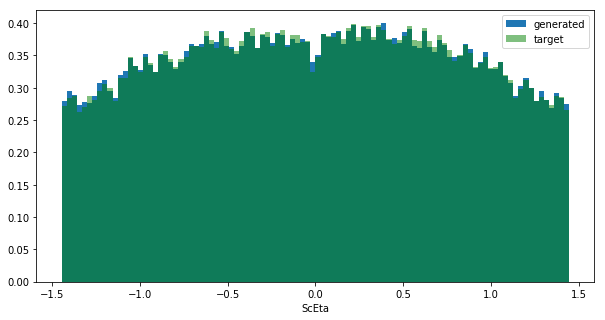

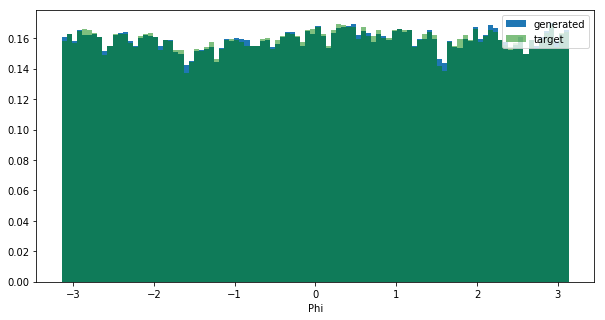

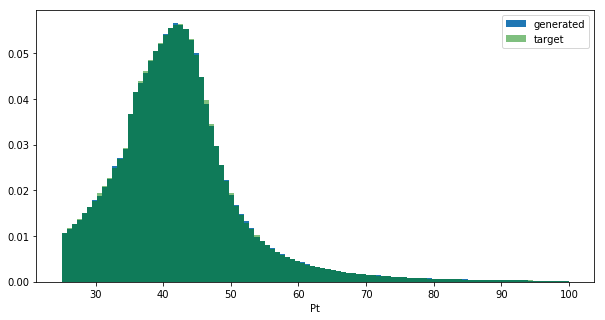

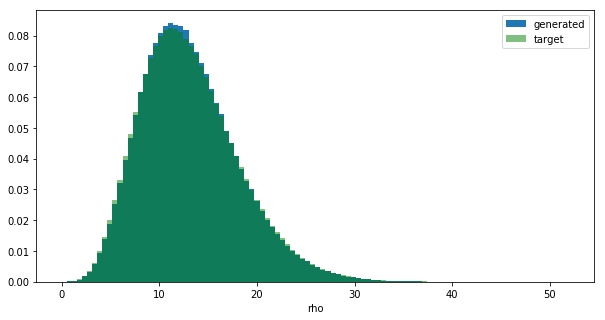

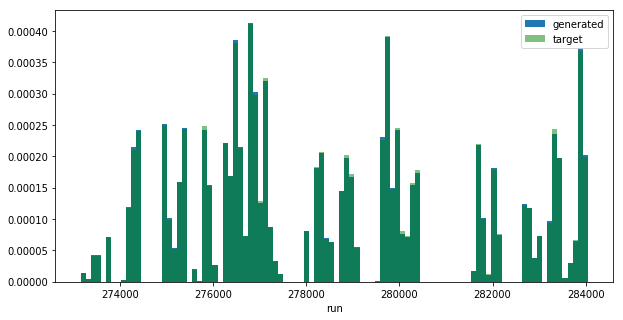

In [40]:
import GAN.plotting as plotting

for feat in features:
    plotting.plot_hists(data_test[feat],mc_test[feat],generated_w=mc_w,bins=100,range=[data_test[feat].min(),data_test[feat].max()])
    plt.xlabel(feat)
    plt.show()


In [41]:
import pickle
from gzip import open as gopen

def to_pickle(name,obj):
    with gopen('%s.pkl.gz' % name,'w+') as out:
        pickle.dump(obj,out)
        out.close()

In [42]:
clf.features_ = features
to_pickle('rewei_zee_5d_barrel',clf)

In [53]:
import GAN.preprocessing as preprocessing
reload(preprocessing)

<module 'GAN.preprocessing' from 'GAN/preprocessing.py'>

In [54]:
mc_w2 = preprocessing.reweight_multidim(mc_test[features],clf)

In [55]:
(mc_w - mc_w2).sum()

0.0

In [46]:
import GAN.utils as utils

In [47]:
clf2 = utils.read_pickle('rewei_zee_5d_barrel')

In [48]:
mc_w2 = preprocessing.reweight_multidim(mc_test[clf2.features_],clf2)

In [49]:
(mc_w - mc_w2).sum()

-1904036.4689229133